<a href="https://colab.research.google.com/github/Rabbia-Ijaz/TryItOut/blob/main/TailorMod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [874]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [875]:
import cv2

import copy
import math
from tensorflow.keras.models import load_model
import tensorflow as tf
import sys
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
import pickle
import numpy as np
import cv2
from random import randint
import os
!pip install blend_modes
from blend_modes import soft_light
from IPython.display import display, Image


In [876]:
def Display(a,title1="test"):
  cv2.imwrite(title1+'.jpg',a)
  print(title1)
  display(Image(filename=title1+'.jpg'))


# User

In [877]:
class User:         #dummy User Class
  def __init__(self, N="", I=0):
    self.Name = N
    self.ID = I
  def UserDetails(self):
    print("Username: "+ self.Name)
    print("User ID: "+ str(self.ID))
  def returnDetails(self):
    return self.Name,self.ID

# Data

In [878]:
class Data:        #Data input class
  def __init__(self, src, tar):
    self.Source = src
    self.Target = tar
  
  def InputResize(self,img):
    return cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)

  def InputData(self):
    x = open("/content/drive/MyDrive/Colab Notebooks/model2.pkl",'rb')
    model = pickle.load(x)
    srcImg = cv2.imread(self.Source)
    targImg = cv2.imread(self.Target)

    Display(srcImg,'src')
    Display(targImg,'tar')

    srcImg = self.InputResize(srcImg)
    targImg = self.InputResize(targImg)


    img = srcImg.flatten()
    srCpred = model.predict([img])
    
    #pred is array: [x1,y1,x2,y2] (x1,y1) top left (x2,y2) bottom right

    SrcBoxStart =( int(srCpred[0][0]), int(srCpred[0][1]))
    SrcBoxEnd = (int(srCpred[0][2]), int(srCpred[0][3]))
    SrcBoxDim = ((SrcBoxEnd[0]-SrcBoxStart[0]), (SrcBoxEnd[1]-SrcBoxStart[1]))    
    size=(SrcBoxDim[1],SrcBoxDim[0],3)
    tempSrc=np.zeros(size, dtype = np.uint8)

    for i in range(0,SrcBoxDim[1]):
      for j in range(0,SrcBoxDim[0]):
        tempSrc[i][j]=srcImg[SrcBoxStart[1]+i][SrcBoxStart[0]+j]
    
    
    targImg = self.InputResize(targImg)
    img2 = targImg.flatten()
    targpred = model.predict([img2])
    x.close()
    TarBoxStart =(int(targpred[0][0]), int(targpred[0][1]))
    TarBoxEnd = (int(targpred[0][2]), int(targpred[0][3]))
    TarBoxDim = ((TarBoxEnd[0]-TarBoxStart[0]), (TarBoxEnd[1]-TarBoxStart[1]))


    return tempSrc, targImg, TarBoxStart, TarBoxEnd
    

# Preprocessing

In [879]:
class PreProcessing:    #Preprocessing class
  def __init__(self):
    print("Preprocessing")

  def KMeansAlgo(self,img,K):
      Z = img.reshape((-1,3))
      # convert to np.float32
      Z = np.float32(Z)
      # define criteria, number of clusters(K) and apply kmeans()
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

      ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
      # Now convert back into uint8, and make original image
      center = np.uint8(center)
      res = center[label.flatten()]
      res2 = res.reshape((img.shape))
      Display(res2,'Kmeans')
      return res,res2

  def firstMin(self,res,uniq):
    min=len(res)
    minColor=-1
    for i in range(0,len(uniq)):
      if ((res==uniq[i]).sum())< min:
        min=(res==uniq[i]).sum()
        minColor=uniq[i]
    return minColor

  def secondMin(self,res,uniq,mini):
    min=len(res)
    minColor=-1
    for i in range(0,len(uniq)):
      if (uniq[i][0]!= mini[0] and uniq[i][1]!= mini[1] and uniq[i][2]!= mini[2]):
        if ((res==uniq[i]).sum())< min:
          min=(res==uniq[i]).sum()
          minColor=uniq[i]
    return minColor

  def FinalDetails(self,srcC,result,res,res2):
      result2=result.copy()
      unique_rows = np.unique(res, axis=0)
      mini1=self.firstMin(res,unique_rows)
      mini2=self.secondMin(res,unique_rows,mini1)
      for i in range(0,res2.shape[0]):
        for j in range(0,res2.shape[1]):
          if (res2[i][j][0]==mini1[0] and res2[i][j][1]==mini1[1] and res2[i][j][2]==mini1[2]) or (res2[i][j][0]==mini2[0] and res2[i][j][1]==mini2[1] and res2[i][j][2]==mini2[2]):
            result2[i][j]=res2[i][j]
          else:
            result2[i][j]=result[i][j]
      return result2

  def Blending(self,source,target,tarStart,tarEnd):
    targBoxDim = ((tarEnd[0]-tarStart[0]), (tarEnd[1]-tarStart[1]))
    size=(targBoxDim[1],targBoxDim[0],3)
    tar=np.zeros(size, dtype = np.uint8)
    targBoxDim = ((tarEnd[0]-tarStart[0]), (tarEnd[1]-tarStart[1]))

    for i in range(0,targBoxDim[1]):
      for j in range(0,targBoxDim[0]):
        tar[i][j]=target[tarStart[1]+i+20][tarStart[0]+j]
    Display(tar)

    sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)

    source2 = cv2.cvtColor(sourceResized, cv2.COLOR_BGR2GRAY ) 
    source2 = cv2.GaussianBlur(source2,(5,5),0)
    thresh = cv2.threshold(source2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    Display(sourceResized)

    
    blended = cv2.addWeighted(sourceResized, 0.2, tar,1, 0)
    
    for i in range(blended.shape[0]):
      for j in range(blended.shape[1]):
        if thresh[i][j]==255:
          blended[i][j]=(255,255,255)
        else:
          blended[i][j]=tar[i][j]

    Display(blended,"blended")
    res,res2=self.KMeansAlgo(sourceResized,4)
    result2=self.FinalDetails(sourceResized,blended,res,res2)
    
    return result2

  

# TailorMod

In [880]:
class TextureMod:    #TextureMod model class
  def __init__(self):
    print ("The TextureMod model has been created")

  def checkOutliers (self,val):
    upperLimit = 230
    lowerLimit = 25
    if (all([val[0] <upperLimit, val[1]<upperLimit, val[2]<upperLimit]) and all([val[0] > lowerLimit, val[1] > lowerLimit, val[2] > lowerLimit])):
      return True
    else:
      return False

  def rotate(self,image, angle, center = None, scale = 1.0):
      (h, w) = image.shape[:2]

      if center is None:
          center = (w / 2, h / 2)

      # Perform the rotation
      M = cv2.getRotationMatrix2D(center, angle, scale)
      rotated = cv2.warpAffine(image, M, (w, h))

      return rotated

  def maskMaker(self, points, canvasSize):
    canvas=np.zeros(canvasSize, np.uint8)
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(canvas,[pts],True,(255))
    maskThresh = cv2.threshold(canvas, 120, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(maskThresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(canvas, [c], -1, (255,255,255), -1)
    return canvas

  def getDifference (self,sourceLines, targetLines, targBoxStart, targBoxEnd, targBoxDim):
    cons = [0,0,0,0]
    check=[0,0,0,0]
    for i in range (targBoxDim[0]):
        if (sourceLines[i][0] == 255 and check[0]==0):
            cons[0]=i
            check[0]=1
        if (targetLines[i][targBoxStart[0]] == 255 and check[1]==0):
            cons[2]=i
            check[1]=1
        if (sourceLines[i][targBoxDim[0]-1] == 255 and check[2]==0):
            cons[1]=i
            check[2]=1
        if (targetLines[i][targBoxStart[0] + targBoxDim[0]] == 255 and check[3]==0):
            cons[3]=i
            check[3]=1
    return cons
  
  def Mapping(self,source,target,targBoxDim,targBoxStart,targBoxEnd):
    
    targetLines = cv2.Canny(target, 100, 200)
    sourceDim = source.shape[0:1]
    targetDim = target.shape[0:1]

    sourceResized = cv2.resize(source, targBoxDim, interpolation=cv2.INTER_AREA)


    sourceLines = cv2.Canny(sourceResized, 100, 200)
    sourceConnect1, sourceConnect2,  targetConnect1, targetConnect2 = self.getDifference(sourceLines, targetLines, targBoxStart, targBoxEnd, targBoxDim)
    leftDif = targetConnect1 - sourceConnect1

    count = 0

    side1 = np.sqrt((targBoxDim[1])**2 + (sourceConnect2-sourceConnect1)**2)
    side2 = np.sqrt((targBoxDim[1])**2 + (targetConnect2-targetConnect1)**2)
    oppSide = targetConnect2 - sourceConnect2

    #Adding border to source for safe rotation
    borderSize = int(sourceResized.shape[0]/2)
    print("border size : " + str(borderSize))
    sourceWB = cv2.copyMakeBorder(sourceResized, top = borderSize, bottom = borderSize, left = borderSize, right = borderSize, borderType=cv2.BORDER_CONSTANT, value = (255, 255, 255))
    if (oppSide != 0):
      print ("side 1 : " + str(side1) +"   side 2 : " + str(side2) + "   opposite side : " + str(oppSide))
      degree = ((side1**2) + (side2**2)-(oppSide**2))/(2*side1*side2)
      degree = math.acos(degree)*15
      print ("degreee : " + str(degree))
      sourceRotated = self.rotate(sourceWB, degree, center = (0 + borderSize, sourceConnect1 + borderSize))
    else:
      sourceRotated = copy.deepcopy(sourceWB)

    #Changing the size back to original
    sourceRotated = sourceRotated[borderSize:borderSize+sourceResized.shape[0], borderSize:borderSize+sourceResized.shape[1]]
    Display(sourceRotated, "SOURCE WB")

    sourceLines = cv2.Canny(sourceRotated, 100, 200)

    difference = 0
    result = copy.deepcopy(target)

    if (sourceConnect1>targetConnect1):
      difference = sourceConnect1-targetConnect1
      result = cv2.copyMakeBorder(result, top = difference, bottom = 0, left = 0, right = 0, borderType=cv2.BORDER_CONSTANT, value = (255, 255, 255))

    #Mask 1
    points1=[]
    points1.append([targBoxStart[0], targetConnect1+difference])
    point = ((targBoxStart[0] + targBoxEnd[0])/2,targBoxEnd[1])
    temp1=int(point[0])
    temp2=int(point[1])
    points1.append([temp1, temp2])
    points1.append([targBoxEnd[0], targetConnect2+difference])
    points1.append([targBoxEnd[0]+ 5, targBoxEnd[1] + 10])
    points1.append([targBoxStart[0]- 5, targBoxEnd[1] + 10])


    mask1 = self.maskMaker (points1, (target.shape[0]+difference, target.shape[1], 1))
    Display(mask1)

    #Mask for old collar removal
    points2=[]
    points2.append([targBoxStart[0], targetConnect1+difference])
    point = ((targBoxStart[0] + targBoxEnd[0])/2,targBoxEnd[1]-10)
    temp1=int(point[0])
    temp2=int(point[1])
    points2.append([temp1, temp2])
    points2.append([targBoxEnd[0], targetConnect2+difference])
    points2.append([targBoxEnd[0],0])
    points2.append([targBoxStart[0],0])

    mask2 = self.maskMaker (points2, (target.shape[0]+difference, target.shape[1], 1))
    Display(mask2)

    print("mask size : " + str(mask2.shape))
    print("result size : " + str(result.shape))
    for x in range(mask2.shape[0]):
      for y in range(mask2.shape[1]):
        if (mask2[x][y]==255):
          result[x][y]=(255, 255, 255)
    Display(result)

    #Mask to inpaint
    points3=[]
    points3.append([targBoxStart[0], targetConnect1+difference])
    points3.append([targBoxStart[0]+ 5, targBoxEnd[1] - 10])
    points3.append([targBoxEnd[0]- 5, targBoxEnd[1] - 10])
    points3.append([targBoxEnd[0], targetConnect2+difference])
    points3.append([targBoxEnd[0]+ 5, targBoxEnd[1] + 10])
    points3.append([targBoxStart[0]- 5, targBoxEnd[1] + 10])

    mask3 = self.maskMaker (points3, (target.shape[0]+difference, target.shape[1], 1))
    Display(mask3)
    
    for x in range(targBoxStart[0], targBoxEnd[0]):
        for y in range(targBoxStart[1], targBoxEnd[1]):
          if (self.checkOutliers(sourceRotated[y - targBoxStart[1], x - targBoxStart[0]]) and mask1[y + (targetConnect1 - sourceConnect1 + difference), x]!=(255)):
            result[y + (targetConnect1 - sourceConnect1 + difference) ,x]=(255,255,255)

    
    for x in range(targBoxStart[0], targBoxEnd[0]):
        for y in range(targBoxStart[1], targBoxEnd[1]):
          if (self.checkOutliers(sourceRotated[y - targBoxStart[1], x - targBoxStart[0]])):
            result[y + (targetConnect1 - sourceConnect1 + difference), x] = sourceRotated[y - targBoxStart[1], x - targBoxStart[0]]

    Display(result)

    result = cv2.inpaint(result,mask3,3,cv2.INPAINT_TELEA)
    Display(sourceRotated)
    Display(target)

    #Display(result)
    return result
  
  
        

# Result

In [881]:
class Result:    #Result class
  def __init__(self, img):
   self.result=img

  def showResult(self):
    Display(self.result,"FinalResult")
    

# Database

In [882]:
class Database:    #Database class
  def __init__(self, name,id):
   self.Name=name
   self.ID=id
   self.Photos=[]

  def showDatabase(self):
    print("Name: "+ self.Name)
    print("ID: "+ str(self.ID))
    for i in range(0,len(self.Photos)):
      temp="title"+str(i)
      Display(self.Photos[i],temp)

  def AddToDatabase(self,img):
    self.Photos.append(img)
    

# Main

src


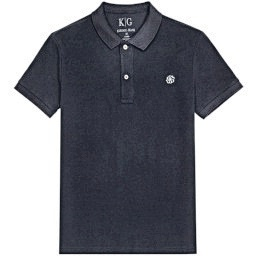

tar


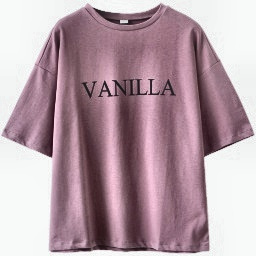

Source


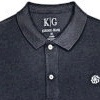

Target


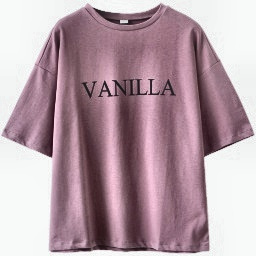

Preprocessing
test


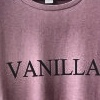

test


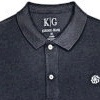

blended


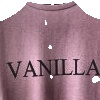

Kmeans


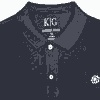

The TextureMod model has been created
border size : 50
side 1 : 100.0199980003999   side 2 : 100.00499987500625   opposite side : -9
degreee : 1.350285282655768
SOURCE WB


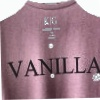

test


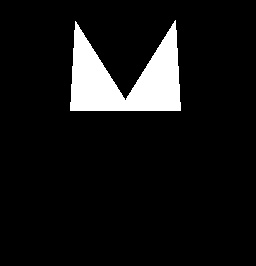

test


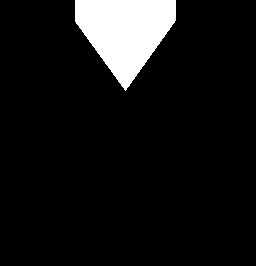

mask size : (266, 256, 1)
result size : (266, 256, 3)
test


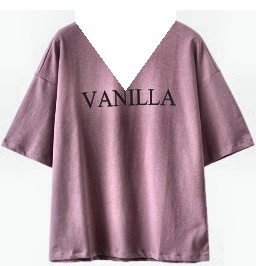

test


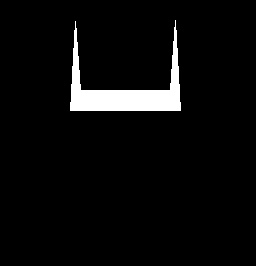

test


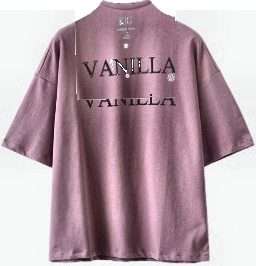

test


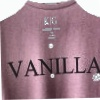

test


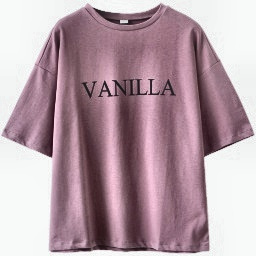

test


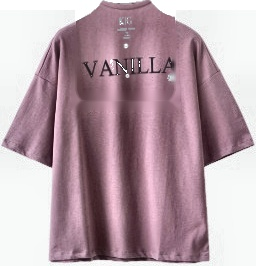

FinalResult


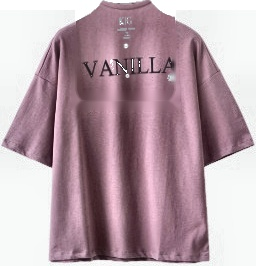

Name: Rabbia
ID: 123
title0


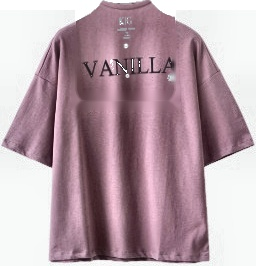

In [883]:
NewUser= User("Rabbia",123)

#NewData=Data("/content/drive/MyDrive/Colab Notebooks/newshirt3.jpg","/content/drive/MyDrive/Colab Notebooks/shirt.jpg")
NewData=Data("/content/drive/MyDrive/Colab Notebooks/newShirt5.jpg","/content/drive/MyDrive/Colab Notebooks/shirt2.jpg")
source, target, targBoxStart, targBoxEnd=NewData.InputData()
Display(source,"Source")
Display(target,"Target")
targBoxDim = ((targBoxEnd[0]-targBoxStart[0]), (targBoxEnd[1]-targBoxStart[1]))


Preprocess=PreProcessing()
source = Preprocess.Blending(source,target, targBoxStart,targBoxEnd)
TextureModel=TextureMod()
result=TextureModel.Mapping(source,target,targBoxDim,targBoxStart,targBoxEnd)

Display(result)

FinalResult=Result(result)
FinalResult.showResult()

Name,ID=NewUser.returnDetails()
DB=Database(Name,ID)
DB.AddToDatabase(result)
DB.showDatabase()